Download CIFAR10 images first and decompress them
```
wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar xzf cifar-10-python.tar.gz
```

In [2]:
import lmdb
import numpy as np
import pickle
import six

In [9]:
def load_cifar_batch(file):
    with open(file, 'rb') as cifar_batch_pickle:
        # unpickle files and read in as dictionary object
        cifar_batch = pickle.load(cifar_batch_pickle)
    return cifar_batch

In [21]:
batch_files = [
    'cifar-10-batches-py/data_batch_1',
    'cifar-10-batches-py/data_batch_2',
    'cifar-10-batches-py/data_batch_3',
    'cifar-10-batches-py/data_batch_4',
    'cifar-10-batches-py/data_batch_5']

In [7]:
batch_files = [
    '../data/cifar-10-batches-py/test_batch'
]

In [5]:
map_size = 10 * 6150000
env = lmdb.open('malevo_cifar10_test_lmdb', map_size=map_size)

In [10]:
img_id = 0
for file in batch_files:
    batch_data = load_cifar_batch(file)
    
    # load and reshape images [N, C, H, W] ... image, channel, height, width
    images = batch_data[b'data'].reshape([-1, 3, 32, 32])
    # reshape to [N, H, W, C] ... image, height, width, channel
    images = images.transpose(0, 2, 3, 1)
    # load labels and filenames for index file
    
    with env.begin(write=True) as txn:
        for image in images:
            str_id = '{:08}'.format(img_id)
            data = image.tobytes()
            txn.put(str_id.encode('ascii'), data)
            img_id += 1

In [11]:
with env.begin() as txn:
    print(txn.stat())

{'branch_pages': 1L, 'leaf_pages': 65L, 'overflow_pages': 10000L, 'psize': 4096L, 'depth': 2L, 'entries': 10000L}


In [18]:
import math
from PIL import Image

In [19]:

img_ids = [1, 2, 3, 4]
n_imgs = len(img_ids)

env = lmdb.open('lmdb_cifar10_test_lmdb')

n_w = 10
n_h = int(math.ceil(n_imgs / float(n_w)))

width = n_w * 32
height = n_h * 32

master = Image.new(mode='RGB', size=(width, height), color=(0, 0, 0))  # fully transparent

k = 0
with env.begin() as txn:
    for i in range(0, n_h):
        for j in range(0, n_w):
            if k == n_imgs:
              break
            str_id = '{:08}'.format(img_ids[k])
            img = Image.fromarray(np.frombuffer(txn.get(str_id), dtype=np.uint8).reshape((32, 32, 3)))
            master.paste(img, (j * 32, i * 32))

            k += 1

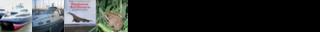

In [20]:
master